# Project 2: Practice with a Monte Carlo simulation
Some problems are complex and solving them one point at a time is wasteful. Instead the approach of randomly evaluating a point can lead to overall trends as the number of random evaluations becomes large. This is a time efficient method. We will examine a calculation using a Monte Carlo approach.

## Objective:

Consider a pendulum formed by a bob of mass $m$ suspended from a fixed point (hinge) by a rod of length $L$. Assume the following: (1) the rod is rigid, non-extensible and its weight is negligible. (2) There is no friction and (3) The pendulum moves in a vertical plane under the gravitational field. When the oscillations are small, the period of the pendulum becomes

$$\tau_{0}=2\pi\sqrt{\frac{L}{g}}$$

However, this changes as oscillations become larger. The goal of this project is to write a Monte Carlo code to determine the period of pendulum as a function of the amplitude $\theta_{\text{max}}$. To accomplish this you will:

1. Derive the large angle period formula by starting from the conservation of energy and using the <code>sympy</code> package to simplify the algebra.

2. From the final result, translate it into a function that accepts
    - A variable angle
    - The initial angle
    - The length of the string
    - The gravity of the system

1. Write a code that numerically solves determines the pendulum of a period in terms of physical quantities of the problem. To do this, you will calculate the integral for $N = 50$ points for $\theta_{\text{max}}$ equally spaced between $\theta$ and $\pi$).

2. Run this calculation for different number of random points $N_{MC} = 10^{1}, 10^{2}, 10^{3}$.


## Solutions:

1. We begin by importing the relevent packages

In [79]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-notebook')

import sympy as sym

Using <code>sympy</code> we can define our independent variables and function

In [80]:
t = sym.Symbol('t', real=True, positive=True)
theta = sym.Function('\\theta')(t)

An the constants

In [81]:
m, g, L = sym.symbols('m, g, L', real=True, positive=True)

The figure below visualizes the system we wish to evaluate

<img src="pendulum.png"
     alt="A pendulum of length L with a mass of m starting at some initial angle at time t=0."
     width="500"
     height="450" />

The conservation of energy dictates that the sum of all energies in this system must cancel, or

$$\sum E_{\text{system}} = 0.$$

Seeing that there is only kinetic and potential energy that governs the motion of this pendulum, we can represent them respectively as

$$K = \frac{1}{2}I\omega^{2},~V = mgh$$

where $I$ is the moment of intertia of the pendulum and $h$ is the height difference from the initial starting point and the point under evaluation. Adding these together, the potential energy has a negative value gravity has a negative magnitude as it "points" in the negative direction yielding

$$0 = \frac{1}{2}I\omega^{2}-mg\Delta h.$$

Before we go about coding this, we can further break down some variables to more fundamental components. $I$ for example can be found trivially

$$I = \int dm~r^{2}|_{r = L} = mL^{2},$$

the height difference by observation is

$$\Delta h = \cos(\theta(t))-\cos(\theta_{0}),$$

and the angular frequency is defined as the rate of change of the angle or $\omega \equiv \frac{d\theta}{dt}$. So we can start from the following equation

$$0 = \frac{1}{2}m\left(L\dot{\theta}\right)^{2}-mgL\left[\cos(\theta(t))-\cos(\theta_{0})\right]$$

In [82]:
K = sym.Rational(1,2)*m*(L*sym.diff(theta))**2
V = m*g*L*(sym.cos(theta)-sym.cos(theta.subs(t,0)))
conservation = sym.Eq(K,V)
solutions= sym.solve(conservation, sym.diff(theta))

<code>solutions</code> has two solutions in a list, one positive and one negative because we have to take the square root of the entire equation at one point in the simplification. We select only the even solution as the period $\tau$ must be a positive number so now $\frac{d\theta}{dt}$ is represented as

In [83]:
dtheta = solutions[1]
dtheta

sqrt(2)*sqrt(g)*sqrt(-cos(\theta(0)) + cos(\theta(t)))/sqrt(L)

Our current equation has units of $1/\text{time}$ so we invert the entire equation and integrate with respect to $\theta$ with the lowest point in the swing being at $\theta=0$

In [84]:
t = sym.Integral(dtheta**(-1), (theta, 0, theta.subs(t,0)))
t


Integral(sqrt(2)*sqrt(L)/(2*sqrt(g)*sqrt(-cos(\theta(0)) + cos(\theta(t)))), (\theta(t), 0, \theta(0)))

And because this takes place in one of the four quadrants of the rotation, we multiply this quantity by 4 to get the period

In [85]:
T = 4*t
T

4*Integral(sqrt(2)*sqrt(L)/(2*sqrt(g)*sqrt(-cos(\theta(0)) + cos(\theta(t)))), (\theta(t), 0, \theta(0)))

2. From here, we can create our function such that we represent the integrand (we could continue with the <code>lambdify</code> method but for clarity we will code it from scratch). 

In [86]:
def integrand(theta, initial, length, gravity):
    return 4*(2*(gravity/length)*(np.cos(theta)-np.cos(initial)))**(-1/2)
integrand(0,np.pi, 1, 9.8)

0.6388765649999399

3. 

In [87]:
def integral(start, stop, N_pts, sample, *args):
    
    random_theta = np.random.uniform(start, sample, N_pts)
    
    Integral = np.sum(integrand(random_theta,*args))
    
    return Integral*(stop-start)/N_pts

4. 

In [88]:
def evaluate(start, stop, N_pts, N_evals, *args):
    
    theta_array = np.linspace(start, stop, N_pts)
    
    solution_array = np.zeros((N_evals, N_pts))
    
    for idx in range(N_evals):
        for jdx, j in enumerate(theta_array):
            solution_array[idx,jdx] = integral(start, stop, N_pts, j, *args)
    return theta_array, solution_array

In [89]:
gravity = 9.8
length = 1
initial = np.pi
N_pts = 20
start, stop = 0, np.pi

Text(0, 0.5, 'Period [seconds]')

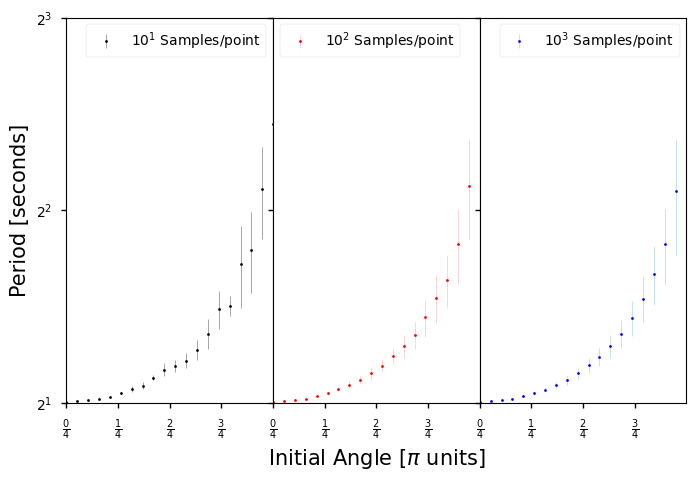

In [90]:

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(8,5), sharex = True, sharey=True)
plt.subplots_adjust(hspace=0, wspace=0)
colors = ['k', 'r', 'b']
ecolors = ['gray', 'pink', 'lightblue']
labels = ['$10^{1}$', '$10^{2}$', '$10^{3}$']
for i in range(3):
    thetas, solutions = evaluate(start, stop, N_pts, 10**(i+1), initial, length, gravity)  
    ax[i].errorbar(x= thetas/np.pi, y = np.abs(np.mean(solutions, axis=0)), yerr = np.abs(np.std(solutions, axis=0)),
                marker='o', linewidth =0, markersize=2, elinewidth=0.5, ecolor = ecolors[i], color=colors[i], label = labels[i] + ' Samples/point')
    ax[i].legend(loc='best')
    
ax[0].set_yscale('log', base=2)
ax[0].set_ylim([2**1, 2**3])
ax[0].set_xlim([0, 1])
ax[0].set_xticks(np.arange(0,1,0.25))
ax[0].set_xticklabels(['$\\frac{0}{4}$', '$\\frac{1}{4}$', '$\\frac{2}{4}$', '$\\frac{3}{4}$'])
ax[1].set_xlabel('Initial Angle [$\\pi$ units]', fontsize=15)
ax[0].set_ylabel('Period [seconds]', fontsize=15)
    